# USING LAPLACE TRANSFORMS (LTs) - Part 2

This notebook demonstrates how Laplace transforms and transfer functions can be derived directly from a chemical model.

What we present is *not* a general technique. It only works if the underlying network can be represented by a system of linear differential equations. In practice this means that: (a) all reactions have a single reactant and (b) the kinetics are masss action.

We use the following notation:
* $s$: Laplace transform variable
* $G(s)$: Transfer function
* $S_n$: $n$-th chemical species
* $x_n (t), ~ x_n$: Concentration of $S_n$ at time $t$
* $\dot{x}_n (t), ~ \dot{x}_n$: First derivative of $x(t)$
* $X_n(s)$: Laplace Transform of the concentration of $S_n$

Reactions are described by arrows. The annotation above the arrow is the reaction rate. (Previously, we had assumed mass action kinetics and so just used the kinetic constants.) For example, $S_1$ is converted to $S_2$ at a rate $kx_1$ (where $x_1$ is the concentration of $S_1$ at time $t$) is denoted by $S_1 \xrightarrow{kx_1} S_2$.

This section introduces some more advanced analysis and the use of symbolic algebra.

# Preliminaries

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import sympy
import tellurium as te

# Helpers

In [2]:
class PlotResult(object):

    def __init__(self, times=None, yt=None, ax=None):
        self.times = times
        self.yt = yt
        self.ax = ax
        
    def __repr__(self):
        return ""

In [3]:
def plotTF(tf, times=None, is_plot=True, figsize=(5,5)):
    if times is None:
        times = np.linspace(0, 10, 100)
    _, yt = control.forced_response(tf, T=times, U=1)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.plot(times, yt)
        ax.set_xlabel("time")
    else:
        ax = None
    return PlotResult(times=times, yt=yt, ax=ax)

# Tests
tf = control.TransferFunction([1], [1, 0])
plot_result = plotTF(tf, is_plot=False)
assert(isinstance(plot_result, PlotResult))
print("OK!")

OK!


# Model 2 With Initial Conditions

We add an initial condition to the system input, $S_1$. Let $x_1(0)$ be 10.
This doesn't change the system equations or the Laplace transform. But it does
change the evaluation of the system.

In [4]:
# Construct the transfer function for G(s) at k1=1
k1, k2, k3 = 1, 2, 3
G_tf = control.TransferFunction([k2*k1], [1, k2+k3, k2*k3])
G_tf

TransferFunction(array([2]), array([1, 5, 6]))

## Predicting the response to initial conditions

The key consideration is to add initial conditions to the step response.

In [5]:
print(G_tf)


      2
-------------
s^2 + 5 s + 6



In [39]:
ss = control.tf2ss(G_tf)
ss

StateSpace(array([[-5., -6.],
       [ 1.,  0.]]), array([[1.],
       [0.]]), array([[0., 2.]]), array([[0.]]))

The key question is "what is the definition of the initial states for a transfer function"?

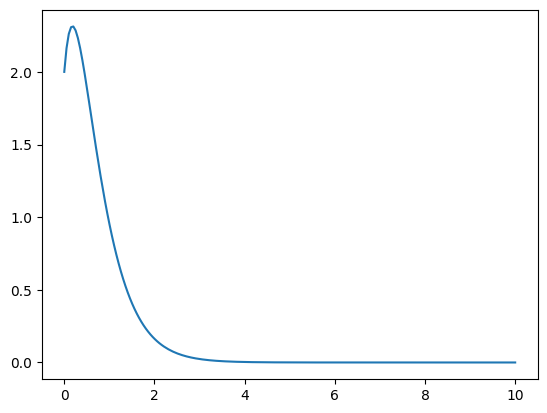

In [49]:
# Initialize constants
times = np.linspace(0, 10, 200)
initial_state = np.array([0, 10])  # Specifies the initial values of S1, S2
#new_times, y_initial = control.initial_response(G_tf, times, initial_state)
new_times, y_initial = control.impulse_response(G_tf, times, 1)
# Plot the results
plt.plot(new_times, y_initial)

The response to initial conditions is what happens if $S_1$ is 10 at time 0 and then the network receives no further input.

## Simulate in Antimony

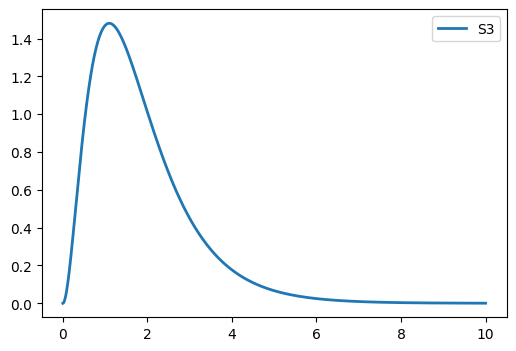

In [7]:
# Model for a unit step response
model = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
k3 = 3
"""
rr = te.loada(model)
rr.simulate(0, 10, 1000, selections=['time', 'S3'])
rr.plot()

## Initial conditions with step response

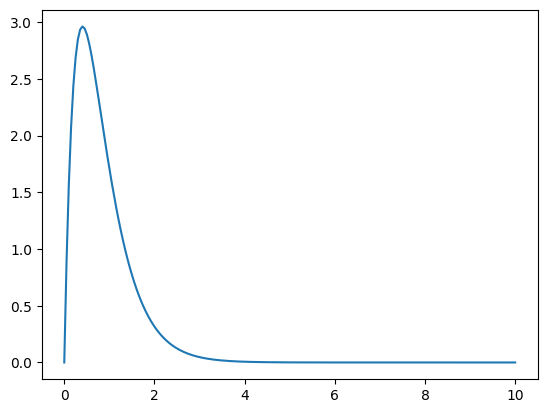

In [16]:
# Initialize constants
times = np.linspace(0, 10, 200)
initial_state = np.array([10, 0])  # Specifies the initial values of S1, S2
_, y_initial = control.initial_response(G_tf, times, initial_state)
# Step response
# Plot the results
plt.plot(times, y_initial)

# Branching pathway controlling $s_3$


\begin{eqnarray}
s_1 & \xrightarrow{k_1 s_1} s_2 \\
s_2 & \xrightarrow{k_2 s_2} s_1 \\
s_1 & \xrightarrow{k_3 s_1} s_3 \\
 & \xrightarrow{k_1 u} s_2 \\
\end{eqnarray}

We want the transfer function from the input $u(t)$ to the output $s_3(t)$.

## 1. System equations

\begin{eqnarray}
\dot{s}_1 & = & k_2 s_2 - k_1 s_1 - k_3 s_1  \\
\dot{s}_2 & = & -k_2 s_2 + k_1 s_1 + k_1 u \\
\dot{s}_3 & = & k_3 s_1  \\
\end{eqnarray}

## 2. LT of system equations

\begin{eqnarray}
s S_1(s) & = & k_2 S_2(s) - k_1 S_1 (s) - k_3 S_1 (s)  \\
s S_2 (s) & = & -k_2 S_2 (s) + k_1 S_1 (s) + k_1 U(s) \\
s S_3(s) & = & k_3 S_1 (s) \\
\end{eqnarray}

## 3. Calculate transfer function

We want $G(s) = \frac{S_3 (s)}{U(s)}$.

We can transform the third system equation so that we have $S_1 (s)$
in terms of $S_3 (s)$. That is,

\begin{eqnarray}
s S_3(s) & = & k_3 S_1 (s) \\
S_1 (s) & = & \frac{S_3(s) s}{k_3}  \\
\end{eqnarray}

We can also express $S_2 (s)$ in terms of $U(s)$ and $S_3(s)$.
\begin{eqnarray}
s S_2 (s) & = & -k_2 S_2 (s) + k_1 S_1 (s) + k_1 U(s) \\
S_2 (s) (s + k_2) & = &  k_1 \frac{s S_3(s)}{k_3}  + k_1 U(s) \\
S_2 (s)  & = &  \frac{1}{s + k_2} \left( k_1 \frac{s S_3(s)}{k_3}  + k_1 U(s) \right) \\
\end{eqnarray}

This allows us to substitute into the second system equation to obtain
the desired result.

\begin{eqnarray}
S_1(s) (s + k_1 + k_3) & = & k_2 S_2(s) \\
\frac{sS_3(s)}{k_3}   (s + k_1 + k_3) & = & k_2 \frac{1}{s + k_2} \left( k_1 \frac{s S_3(s) }{k_3}  + k_1 U(s) \right) \\
\end{eqnarray}

In [8]:
s3, s1, s, k1, k2, k3, s2, u = sympy.symbols("s3, s1, s, k1, k2, k3, s2, u")

In [9]:
expr = s3*s/k3*(s + k1 + k3) -( k2/(s + k2)*(k1*s3*s/k3 + k1*u))
expr

-k2*(k1*u + k1*s*s3/k3)/(k2 + s) + s*s3*(k1 + k3 + s)/k3

In [10]:
sympy.solve(expr, s3)

[k1*k2*k3*u/(s*(k1*s + k2*k3 + k2*s + k3*s + s**2))]

In [11]:
s3 = sympy.solve(expr, s3)[0]
s3

k1*k2*k3*u/(s*(k1*s + k2*k3 + k2*s + k3*s + s**2))

In [12]:
print(sympy.latex(s3))

\frac{k_{1} k_{2} k_{3} u}{s \left(k_{1} s + k_{2} k_{3} + k_{2} s + k_{3} s + s^{2}\right)}


$G(s) = \frac{S_3(s)}{U(s)} = \frac{k_{1} k_{2} k_{3} }{s \left(k_{1} s + k_{2} k_{3} + k_{2} s + k_{3} s + s^{2}\right)}$

## 4. Predict step response

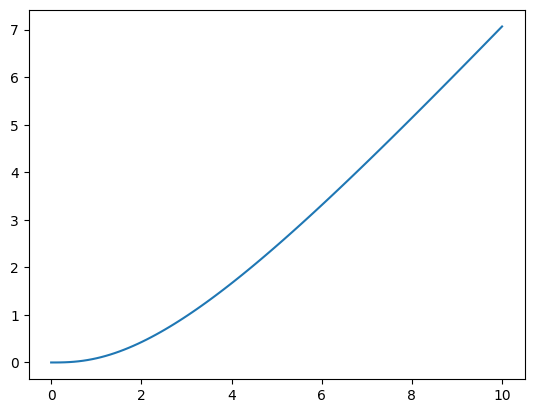

In [13]:
# Initialize constants
k1, k2, k3 = (1, 1, 1)
times = np.linspace(0, 10, 100)
# Response to input
tf = control.TransferFunction([k1*k2*k3],
                              [1, k1+k2+k3, k2*k3, 0])
_, yt = control.forced_response(tf, T=times, U=1)
# Plot the results
plt.plot(times, yt)

In [14]:
tf.poles()

array([-2.61803399+0.j, -0.38196601+0.j,  0.        +0.j])

## 5. Simulate in Antimony

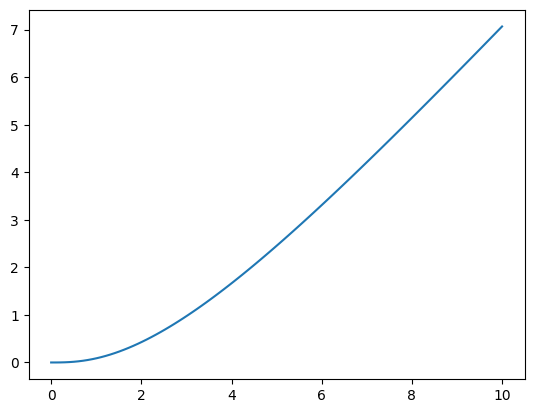

In [15]:
model = """
s1 -> s2; k1*s1
s2 -> s1; k2*s2
s1 -> s3; k3*s1
$u -> s2; k1*u

k1 = 1
k2 = 1
k3 = 1
s1 = 0
s2 = 0
s3 = 0
$u = 1
"""
rr = te.loada(model)
data = rr.simulate(0, 10, 100)
plt.plot(data["time"], data["[s3]"])

## 6. Analyze

$G(s) = \frac{S_3(s)}{U(s)} = \frac{k_{1} k_{2} k_{3} }{s \left(k_{1} s + k_{2} k_{3} + k_{2} s + k_{3} s + s^{2}\right)}$

Some observations
1. The DC gain is infinite and so we expect an unbounded effect
from a step response.
1. An infinite DC gain makes sense since mass accumulates in $S_3$.
1. The initial part of the step response is a quadratic, which results from
populating $s_1$ from $s_2$.

# Fork and Join

This analysis introduces a transfer function with a zero in the transfer function, a value of $s$ that causes the transfer function to go to 0.

\begin{eqnarray}
s_1 & \xrightarrow{k_{1a} s_1} s_2 \\
s_1 & \xrightarrow{k_{1b} s_3} s_3 \\
s_2 & \xrightarrow{k_2 s_2} s_4 \\
s_3 & \xrightarrow{k_3 s_3} s_4 \\
s_4 & \xrightarrow{k_4 s_4} \emptyset \\
\end{eqnarray}